In [291]:
import os

import torch
import torch.nn as nn
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig, AutoModelForSeq2SeqLM
from datasets import load_dataset

import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
softmax_func = torch.nn.functional.softmax
from torch.nn import CrossEntropyLoss, MSELoss, CosineEmbeddingLoss

from utils_quant import QuantizeLinear, TwnQuantizer, QConv1D, MatMul, QMatMul, _gpt2_attn, opt_attn, QuantizeLinear
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

In [1302]:
# gpt_name = f"gpt2"
# gpt2 = AutoModelForCausalLM.from_pretrained(gpt_name)
# gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt_name, use_fast=False)

# neo_name = f"EleutherAI/gpt-neo-1.3b"
# neo_1b = AutoModelForCausalLM.from_pretrained(neo_name)
# neo_tokenizer = AutoTokenizer.from_pretrained(neo_name, use_fast=False)

# neo_name = f"EleutherAI/gpt-neo-2.7b"
# neo_2b = AutoModelForCausalLM.from_pretrained(neo_name)
# neo_tokenizer = AutoTokenizer.from_pretrained(neo_name, use_fast=False)

# size=7
# llama_name = f"huggyllama/llama-{size}b"
# model_llama_7b = AutoModelForCausalLM.from_pretrained(llama_name, cache_dir="/home/ms/hf_cache")
# llama_tokenizer = AutoTokenizer.from_pretrained(llama_name, use_fast=False)

# llama2_name = "meta-llama/Llama-2-7b-hf"
# model_llama2_7b = AutoModelForCausalLM.from_pretrained(llama2_name, force_download=True, resume_download=False)
# llama2_tokenizer = AutoTokenizer.from_pretrained(llama2_name, use_fast=False)

opt_name = f"facebook/opt-125m"
model_opt_125m = AutoModelForCausalLM.from_pretrained(opt_name, cache_dir="/home/ms/hf_cache")
opt_tokenizer = AutoTokenizer.from_pretrained(opt_name, use_fast=False, cache_dir="/home/ms/hf_cache")

# size=1.3
# opt_name = f"facebook/opt-{size}b"
# model_opt_1b = AutoModelForCausalLM.from_pretrained(opt_name, cache_dir="/home/ms/hf_cache")
# opt_tokenizer = AutoTokenizer.from_pretrained(opt_name, use_fast=False, cache_dir="/home/ms/hf_cache")

# size=1.3
# opt_name = f"facebook/opt-{size}b"
# model_opt_1b = AutoModelForCausalLM.from_pretrained(opt_name)
# opt_tokenizer = AutoTokenizer.from_pretrained(opt_name, use_fast=False)

## Quantization

In [1303]:
model_opt = model_opt_125m

In [736]:
import copy
quant_opt = copy.deepcopy(model_opt).to("cpu")

In [745]:
max_scale=0.7
model = quant_opt
layerwise=True
for name, module in tqdm(model.model.named_modules()):
    if "lm_head" not in name:
        if isinstance(module,nn.Linear):
            input = module.weight
            if layerwise:
                # m = input.norm(p=1).div(input.nelement())
                m = input.abs().mean()
                thres = max_scale * m
                pos = (input > thres).float()
                neg = (input < -thres).float()
                mask = (input.abs() > thres).float()
                alpha = (mask * input).abs().sum() / mask.sum()
                result = alpha * pos - alpha * neg
                module.weight.data = result
            else: # row-wise only for embed / weight
                n = input[0].nelement()
                m = input.data.norm(p=1, dim=1).div(n)
                thres = (max_scale * m).view(-1, 1).expand_as(input)
                pos = (input > thres).float()
                neg = (input < -thres).float()
                mask = (input.abs() > thres).float()
                alpha = ((mask * input).abs().sum(dim=1) / mask.sum(dim=1)).view(-1, 1)
                result = alpha * pos - alpha * neg
                module.weight.data = result

138it [00:00, 982.86it/s] 


## Dataset 

In [4]:
def calib_dataset(dataset, block_size, tokenizer, n_samples=20):

    text_name = dataset.column_names[0]
    dataset = dataset.shuffle(seed=52)
    
    len_sum = 0
    samples = []
    n_run = 0
    for data in dataset:
        line = data[text_name]
        line = line.strip()
        line_encoded = tokenizer.encode(line)
#         if len(line_encoded) > 512:
#             continue
        sample = torch.tensor([line_encoded])
        if sample.numel() == 0:
            continue
        samples.append(sample)
        n_run += 1
        if n_run == n_samples:
            break
    cat_samples= torch.cat(samples, dim=1)
    n_split = cat_samples.shape[1] // block_size
    print(f" * Split into {n_split} blocks")
    output = [cat_samples[:, i*block_size:(i+1)*block_size] for i in range(n_split)]
    return output

In [1321]:
seq_len = 512
idx = 3

# dataset = load_dataset('wikitext', 'wikitext-2-raw-v1', split='validation')
# llama_wiki_input_ids = calib_dataset(dataset, seq_len, llama_tokenizer, 200)[idx]
# opt_wiki_input_ids = calib_dataset(dataset, seq_len, opt_tokenizer, 200)[idx]
# neo_wiki_input_ids = calib_dataset(dataset, seq_len, neo_tokenizer, 200)[idx]

dataset = load_dataset('ptb_text_only', split='validation')
# llama_ptb_input_ids = calib_dataset(dataset, seq_len, llama_tokenizer, 200)[idx]
opt_ptb_input_ids = calib_dataset(dataset, seq_len, opt_tokenizer, 200)[idx]
# neo_ptb_input_ids = calib_dataset(dataset, seq_len, neo_tokenizer, 200)[idx]

Found cached dataset ptb_text_only (/home/ms/.cache/huggingface/datasets/ptb_text_only/penn_treebank/1.1.0/8d1b97746fb9765d140e569ec5ddd35e20af4d37761f5e1bf357ea0b081f2c1f)
Loading cached shuffled indices for dataset at /home/ms/.cache/huggingface/datasets/ptb_text_only/penn_treebank/1.1.0/8d1b97746fb9765d140e569ec5ddd35e20af4d37761f5e1bf357ea0b081f2c1f/cache-ecede7cadca0ea47.arrow


 * Split into 10 blocks


In [1305]:
model_opt.config.use_trainer=False
quant_opt.config.use_trainer=False


In [726]:
option_name = "l2l_ms"

model_dir = f"/home/ms/workspace/git/language_modeling/outputs/opt_ptb_40_2bit_{option_name}/pytorch_model.bin"
model_opt.load_state_dict(torch.load(model_dir, map_location="cpu"), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['model.decoder.layers.0.self_attn.matmul1.act_clip_val', 'model.decoder.layers.0.self_attn.matmul2.act_clip_val', 'model.decoder.layers.0.self_attn.k_proj.weight_clip_val', 'model.decoder.layers.0.self_attn.k_proj.act_clip_val', 'model.decoder.layers.0.self_attn.v_proj.weight_clip_val', 'model.decoder.layers.0.self_attn.v_proj.act_clip_val', 'model.decoder.layers.0.self_attn.q_proj.weight_clip_val', 'model.decoder.layers.0.self_attn.q_proj.act_clip_val', 'model.decoder.layers.0.self_attn.out_proj.weight_clip_val', 'model.decoder.layers.0.self_attn.out_proj.act_clip_val', 'model.decoder.layers.0.fc1.weight_clip_val', 'model.decoder.layers.0.fc1.act_clip_val', 'model.decoder.layers.0.fc2.weight_clip_val', 'model.decoder.layers.0.fc2.act_clip_val', 'model.decoder.layers.1.self_attn.matmul1.act_clip_val', 'model.decoder.layers.1.self_attn.matmul2.act_clip_val', 'model.decoder.layers.1.self_attn.k_proj.weight_clip_val', 'model.decoder.laye

In [808]:
fp_logit = outputs_fp["logits"][:,:-1,:]
q_logit = outputs_q["logits"][:,:-1,:]

In [819]:
torch.sum((- targets_prob * student_likelihood), dim=-1).squeeze(0).shape

torch.Size([255])

In [812]:
student_likelihood = torch.nn.functional.log_softmax(q_logit, dim=-1)
targets_prob = torch.nn.functional.softmax(fp_logit, dim=-1)
per_token_logit_dist = torch.sum((- targets_prob * student_likelihood), dim=-1)

In [909]:
for option_name in ["tsld", "logit"]:
    model_dir = f"/home/ms/workspace/git/language_modeling/outputs/opt_ptb_40_2bit_{option_name}/pytorch_model.bin"
    model_opt.load_state_dict(torch.load(model_dir, map_location="cpu"), strict=False)
    output_flag=False
    input_ids = opt_ptb_input_ids
    kwargs = {"input_ids" : opt_ptb_input_ids, "labels" : opt_ptb_input_ids, "output_hidden_states" : output_flag, "use_cache" : output_flag, "output_attentions" : output_flag}
    outputs = model_opt(**kwargs)
    q_logit = outputs["logits"][:,:-1,:]
    student_likelihood = torch.nn.functional.log_softmax(q_logit, dim=-1)
    targets_prob = torch.nn.functional.softmax(fp_logit, dim=-1)
    per_token_logit_dist = torch.sum((- targets_prob * student_likelihood), dim=-1)
    logit_dist[option_name] = per_token_logit_dist

In [834]:
idx = (logit_dist["logit"] - logit_dist["tsld"]).sort(descending=True)[1][0]

In [841]:
logit_dist[f"{option_name}"][:,idx]

torch.Size([1, 255])

In [917]:
(loss_all_dict["tsld"] - loss_all_dict["logit"]).sort(descending=True)

torch.return_types.sort(
values=tensor([ 4.2429e+00,  2.5665e+00,  2.3654e+00,  1.9529e+00,  1.8581e+00,
         1.8560e+00,  1.7506e+00,  1.6049e+00,  1.5509e+00,  1.3368e+00,
         1.3157e+00,  1.2290e+00,  1.1693e+00,  1.1195e+00,  1.1015e+00,
         1.0348e+00,  1.0344e+00,  1.0191e+00,  9.7631e-01,  9.2671e-01,
         8.7553e-01,  7.7705e-01,  7.7101e-01,  7.5079e-01,  7.4665e-01,
         7.2824e-01,  7.2489e-01,  7.0142e-01,  6.9794e-01,  6.9459e-01,
         6.7353e-01,  6.6995e-01,  6.6438e-01,  6.6422e-01,  6.5507e-01,
         6.4926e-01,  6.4884e-01,  6.4871e-01,  6.4401e-01,  6.4188e-01,
         6.3440e-01,  6.2958e-01,  5.8869e-01,  5.6431e-01,  5.5652e-01,
         5.4912e-01,  5.3761e-01,  4.9331e-01,  4.7182e-01,  4.7107e-01,
         4.6460e-01,  4.6334e-01,  4.5870e-01,  4.5249e-01,  4.5175e-01,
         4.3918e-01,  4.3557e-01,  4.3490e-01,  4.2679e-01,  4.0604e-01,
         4.0330e-01,  3.7910e-01,  3.7170e-01,  3.5222e-01,  3.4508e-01,
         3.3001e-01

In [968]:
a = ((loss_all_dict["tsld"] - loss_all_dict["logit"]) > 0)

In [967]:
b = ((loss_all_dict["tsld"] - loss_all_dict["tsld_up_8"]) > 0)

ValueError: All arrays must be of the same length

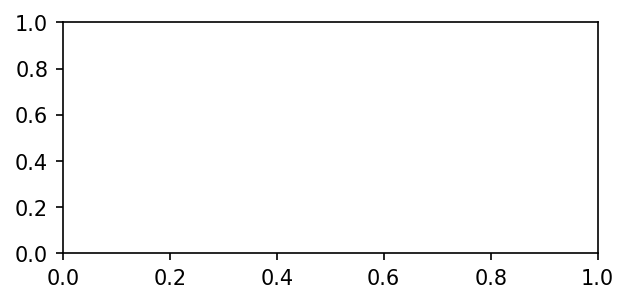

In [1007]:
start = 0
end = 120
color_list = ["dimgray", "tab:orange", "tab:blue", "dodgerblue"]
name_list = ["L2L", "Logit", "TSLD_up", "TSLD"]

fig, axes = plt.subplots(1, 1, figsize=(4.6, 2), dpi=150)
for i,option_name in enumerate(["logit", "tsld_up_8", "tsld"]):
    sns.lineplot(x=np.arange(end-start), y=logit_dist[f"{option_name}"][:,idx[0]][start:end].squeeze(0).detach().cpu().numpy(),  ax=axes, linewidth=1.5, marker="o", linestyle="-", alpha=1, label=name_list[i], color=color_list[i])
    

In [813]:
logit_dist=dict()
logit_dist["l2l"] = per_token_logit_dist

In [1093]:
kwargs = {"input_ids" : opt_ptb_input_ids, "labels" : opt_ptb_input_ids, "output_hidden_states" : output_flag, "use_cache" : output_flag, "output_attentions" : output_flag}
outputs = model_opt(**kwargs)
loss_all_dict[f"FP"] = outputs.loss_all.detach().cpu()

In [1095]:
outputs.keys()

odict_keys(['loss', 'loss_all', 'logits'])

In [1094]:
loss_all_dict = dict()
for option_name in ["logit", "tsld"]:
    model_dir = f"/home/ms/workspace/git/language_modeling/outputs/opt_ptb_40_2bit_{option_name}/pytorch_model.bin"
    model_opt.load_state_dict(torch.load(model_dir, map_location="cpu"), strict=False)
    output_flag=False
    input_ids = opt_ptb_input_ids
    kwargs = {"input_ids" : opt_ptb_input_ids, "labels" : opt_ptb_input_ids, "output_hidden_states" : output_flag, "use_cache" : output_flag, "output_attentions" : output_flag}
    outputs = model_opt(**kwargs)
    loss_all_dict[f"{option_name}"] = outputs.loss_all.detach().cpu()

In [895]:
loss_all_dict.keys()

dict_keys(['l2l_ms', 'logit', 'tsld'])

In [1032]:
idx = (loss_all_dict["logit"] - loss_all_dict["tsld"]).sort(descending=True)[1]

In [1010]:
loss_all_dict.keys()

dict_keys(['l2l_ms', 'logit', 'tsld_up_8', 'tsld'])

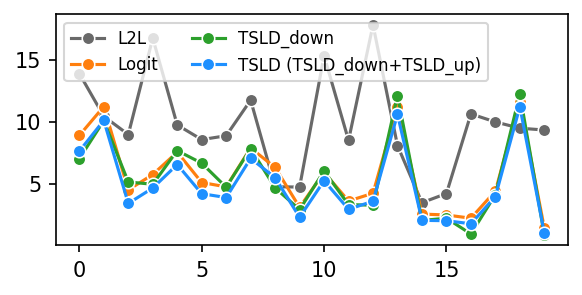

In [1040]:
name_list = ["L2L", "Logit", "TSLD_down", "TSLD (TSLD_down+TSLD_up)"]
color_list = ["dimgray", "tab:orange", "tab:green", "dodgerblue"]
start = 0
end = 20
fig, axes = plt.subplots(1, 1, figsize=(4.4, 2), dpi=150)
for i,option_name in enumerate(["l2l_ms", "logit", "tsld_down_10", "tsld"]):
    sns.lineplot(x=np.arange(end-start), y=loss_all_dict[f"{option_name}"][idx][start:end],  ax=axes, linewidth=1.5, linestyle="-", alpha=1, marker="o", label=name_list[i], color=color_list[i])
    
plt.legend(loc="upper left", ncol=2, fontsize=8)
# from matplotlib.ticker import ScalarFormatter
# formatter = ScalarFormatter(useMathText=True)
# formatter.set_scientific(True)
# formatter.set_powerlimits((0,1)) # 이 설정으로 1e-4, 1e-3 등의 범위에서 과학적 표기법을 사용
# axes.yaxis.set_major_formatter(formatter)
    
    

In [204]:
ce_conf_dict = dict()

In [1322]:
output_flag=True
input_ids = opt_ptb_input_ids
kwargs = {"input_ids" : opt_ptb_input_ids, "labels" : opt_ptb_input_ids, "output_hidden_states" : output_flag, "use_cache" : output_flag, "output_attentions" : output_flag}

outputs_fp = model_opt(**kwargs)

In [750]:
output_flag=True
input_ids = opt_ptb_input_ids
kwargs = {"input_ids" : opt_ptb_input_ids, "labels" : opt_ptb_input_ids, "output_hidden_states" : output_flag, "use_cache" : output_flag, "output_attentions" : output_flag}

outputs_q = quant_opt(**kwargs)

In [658]:
attn_dict["FP"] = outputs_fp["attention_scores"]

In [751]:
attn_dict["l2l_ms_2"] = outputs_q["attention_scores"]

In [619]:
outputs_q["attention_scores"][2].shape

torch.Size([1, 12, 256, 256])

In [649]:
attn_dict = dict()

In [747]:
quant_opt.model.decoder.layers[2].self_attn.k_proj.weight

Parameter containing:
tensor([[ 0.0000,  0.0845,  0.0845,  ...,  0.0845,  0.0000,  0.0845],
        [ 0.0000,  0.0845, -0.0845,  ...,  0.0000,  0.0000, -0.0845],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0845,  0.0000,  0.0000,  ..., -0.0845,  0.0000,  0.0000],
        [ 0.0000, -0.0845,  0.0845,  ...,  0.0000, -0.0845, -0.0845],
        [ 0.0845, -0.0845,  0.0000,  ...,  0.0000,  0.0845,  0.0845]],
       requires_grad=True)

In [709]:
model

Parameter containing:
tensor([[ 0.0000,  0.0000, -0.0890,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0865,  0.0865,  ...,  0.0000, -0.0865,  0.0000],
        [-0.0477,  0.0000,  0.0477,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.1008,  0.1008,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1068, -0.1068,  0.0000,  ...,  0.0000, -0.1068,  0.0000],
        [ 0.1245,  0.1245, -0.1245,  ...,  0.1245,  0.1245, -0.1245]],
       requires_grad=True)

In [1317]:
output_flag=True
input_ids = opt_ptb_input_ids
kwargs = {"input_ids" : opt_ptb_input_ids, "labels" : opt_ptb_input_ids, "output_hidden_states" : output_flag, "use_cache" : output_flag, "output_attentions" : output_flag}

outputs_fp = model_opt(**kwargs)
# attn_dict["l2l_ms_2"] = outputs_fp["attention_scores"]

In [1323]:
tc_all = outputs_fp["loss_all"]
name = "FP"
p_dist = torch.nn.functional.softmax(outputs_fp["logits"][..., :-1, :], dim=-1)
conf_list = p_dist.max(dim=-1)[0].squeeze(0)
entropy_list = torch.distributions.Categorical(probs=p_dist).entropy().squeeze(0)

ce_conf_dict[f"{name}_ce_loss"] = tc_all.detach().cpu().numpy()
ce_conf_dict[f"{name}_conf_list"] = conf_list.detach().cpu().numpy()
ce_conf_dict[f"{name}_entropy_list"] = entropy_list.detach().cpu().numpy()

In [1241]:
for i,option_name in enumerate(["gt_logit"]):
    name = option_name
    model_dir = f"/home/ms/workspace/git/language_modeling/outputs/opt_ptb_40_2bit_{option_name}/pytorch_model.bin"
    model_opt.load_state_dict(torch.load(model_dir, map_location="cpu"), strict=False)

    output_flag=False
    input_ids = opt_ptb_input_ids
    kwargs = {"input_ids" : opt_ptb_input_ids, "labels" : opt_ptb_input_ids, "output_hidden_states" : output_flag, "use_cache" : output_flag, "output_attentions" : output_flag}

    outputs = model_opt(**kwargs)
#     attn_dict[option_name] = outputs["attention_scores"]
    
    tc_all = outputs["loss_all"]
    p_dist = torch.nn.functional.softmax(outputs["logits"][..., :-1, :], dim=-1)
    conf_list = p_dist.max(dim=-1)[0].squeeze(0)
    entropy_list = torch.distributions.Categorical(probs=p_dist).entropy().squeeze(0)

    ce_conf_dict[f"{name}_ce_loss"] = tc_all.detach().cpu().numpy()
    ce_conf_dict[f"{name}_conf_list"] = conf_list.detach().cpu().numpy()
    ce_conf_dict[f"{name}_entropy_list"] = entropy_list.detach().cpu().numpy()

In [1134]:
ce_conf_dict.keys()

dict_keys(['FP_ce_loss', 'FP_conf_list', 'FP_entropy_list', 'l2l_ms_ce_loss', 'l2l_ms_conf_list', 'l2l_ms_entropy_list', 'logit_ce_loss', 'logit_conf_list', 'logit_entropy_list', 'tsld_ce_loss', 'tsld_conf_list', 'tsld_entropy_list'])

In [669]:
# 두 번째 dimension의 각 column을 해당 column의 index+1로 나누기
divisors_rev = torch.arange(seq_len,0, -1).float()
divisors = torch.arange(1, seq_len+1).float()

In [864]:
attn_dict.keys()

dict_keys(['FP', 'Q', 'l2l_ms', 'logit', 'tsld', 'l2l_ms_2'])

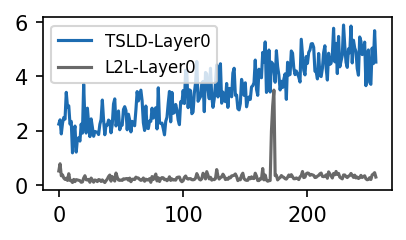

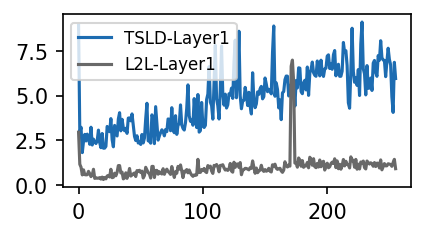

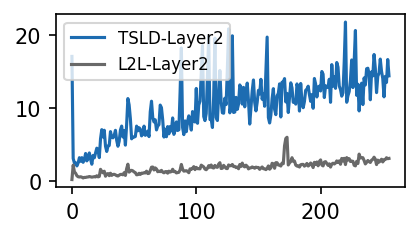

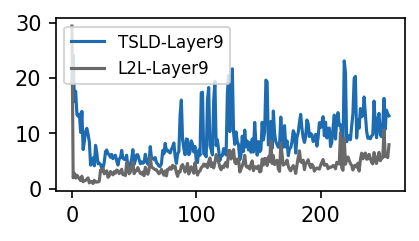

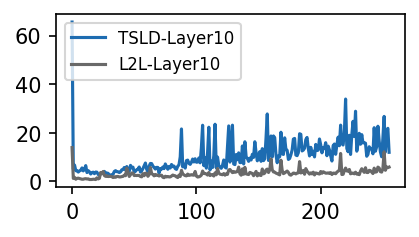

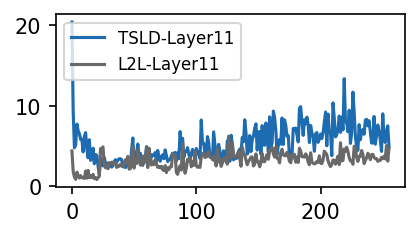

In [877]:
mse_none = MSELoss(reduction="none")


palette_1 = sns.color_palette("Oranges",12)
palette_2 = sns.color_palette("Blues",12)
# palette_3 = sns.color_palette("Grays",12)



for i, l in enumerate([0,1,2, 9,10,11]):
    fig, axes = plt.subplots(1, 1, figsize=(3, 1.5), dpi=150)
#     option_name="logit"
#     fp_attn_layer = attn_dict["FP"][l]
#     q_attn_layer = attn_dict[option_name][l]

#     tc_score = fp_attn_layer.squeeze(0).detach().cpu()
#     st_score = q_attn_layer.squeeze(0).detach().cpu()
#     mse_all = mse_none(tc_score, st_score)
#     per_token_mse = (mse_all.sum(dim=2) / divisors).mean(dim=0)
#     sns.lineplot(x=np.arange(seq_len), y=per_token_mse, color=palette_1[8], ax=axes, label=f"Logit-{l}", linewidth=1.5)
    
    option_name="tsld"
    fp_attn_layer = attn_dict["FP"][l]
    q_attn_layer = attn_dict[option_name][l]

    tc_score = fp_attn_layer.squeeze(0).detach().cpu()
    st_score = q_attn_layer.squeeze(0).detach().cpu()
    mse_all = mse_none(tc_score, st_score)
    per_token_mse = (mse_all.sum(dim=2) / divisors).mean(dim=0)
    sns.lineplot(x=np.arange(seq_len), y=per_token_mse, color=palette_2[9], ax=axes, label=f"TSLD-Layer{l}", linewidth=1.5)
    
    option_name="l2l_ms_2"
    fp_attn_layer = attn_dict["FP"][l]
    q_attn_layer = attn_dict[option_name][l]

    tc_score = fp_attn_layer.squeeze(0).detach().cpu()
    st_score = q_attn_layer.squeeze(0).detach().cpu()
    mse_all = mse_none(tc_score, st_score)
    per_token_mse = (mse_all.sum(dim=2) / divisors).mean(dim=0)
    sns.lineplot(x=np.arange(seq_len), y=per_token_mse, color="dimgray", ax=axes, label=f"L2L-Layer{l}", linewidth=1.5)
#     plt.ylim(0, 10)
    plt.legend(loc="upper left", fontsize=8)
    # print(axes.get_ylim())

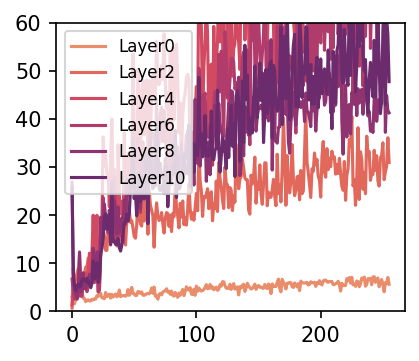

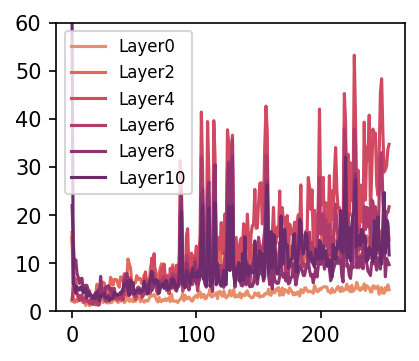

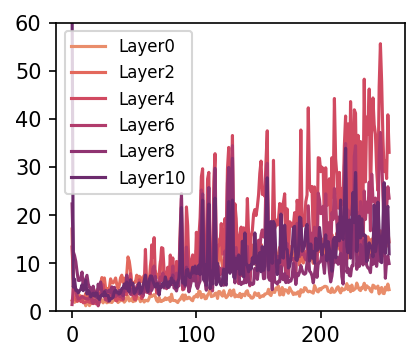

In [789]:
mse_none = MSELoss(reduction="none")


palette_1 = sns.color_palette("flare",6)
palette_1 = sns.color_palette("flare",6)
for i,option_name in enumerate(["Q", "logit", "tsld"]):
    fig, axes = plt.subplots(1, 1, figsize=(3, 2.5), dpi=150)
    for i, l in enumerate([0,2,4,6,8,10]):
        fp_attn_layer = attn_dict["FP"][l]
        q_attn_layer = attn_dict[option_name][l]

        tc_score = fp_attn_layer.squeeze(0).detach().cpu()
        st_score = q_attn_layer.squeeze(0).detach().cpu()
        mse_all = mse_none(tc_score, st_score)
        per_token_mse = (mse_all.sum(dim=2) / divisors).mean(dim=0)
        sns.lineplot(x=np.arange(seq_len), y=per_token_mse, color=palette_1[i], ax=axes, label=f"Layer{l}", linewidth=1.5)
        plt.ylim(0, 60)
        plt.legend(loc="upper left", fontsize=8)
        # print(axes.get_ylim())

In [1101]:
name="logit"

In [1333]:
tc_all = outputs["loss_all"]
p_dist = torch.nn.functional.softmax(outputs_fp["logits"][..., :-1, :], dim=-1)
conf_list = p_dist.max(dim=-1)[0].squeeze(0)
entropy_list = torch.distributions.Categorical(probs=p_dist).entropy().squeeze(0)

ce_conf_dict[f"{name}_ce_loss"] = tc_all.detach().cpu().numpy()
ce_conf_dict[f"{name}_conf_list"] = conf_list.detach().cpu().numpy()
ce_conf_dict[f"{name}_entropy_list"] = entropy_list.detach().cpu().numpy()

In [1104]:
ce_conf_dict = dict()

In [1316]:
len(ce_conf_dict[f"{name}_entropy_list"])

511

(-0.7650000000000001, 16.065)
(-0.42500000000000004, 8.925)


/tmp/ipykernel_1979801/2080976322.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((0, 0), 3, 2, color='orange', alpha=0.5, edgecolor='none', linewidth=0)
/tmp/ipykernel_1979801/2080976322.py:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((3, 2), 5.5, 13.3, color='dodgerblue', alpha=0.5, edgecolor='none', linewidth=0)


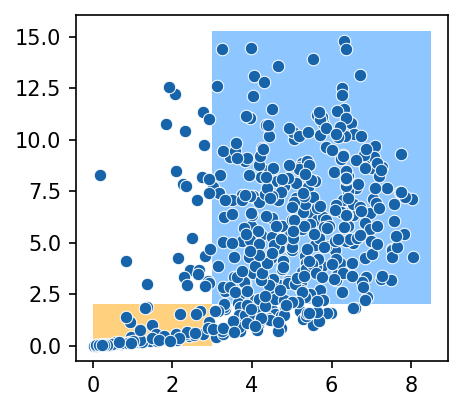

In [1329]:
# label_list = ["Logit", "TSLD_up", "FP"]
palette = sns.color_palette("Blues",24)
label_list = ["FP"]
color_list = [palette[19], "tab:orange", "tab:gray"]
fig, axes = plt.subplots(1, 1, figsize=(3.2, 3), dpi=150)

# axes.axvspan(0, 0.4, facecolor="blue", alpha=0.2)
# axes.axhspan(2, 14, facecolor="blue", alpha=0.2)
# axes.axvspan(0, 0.4, facecolor="blue", alpha=0.2)
from matplotlib.patches import Rectangle
rect = Rectangle((0, 0), 3, 2, color='orange', alpha=0.5, edgecolor='none', linewidth=0)
axes.add_patch(rect)
rect = Rectangle((3, 2), 5.5, 13.3, color='dodgerblue', alpha=0.5, edgecolor='none', linewidth=0)
axes.add_patch(rect)

for i, name in enumerate(["FP"]):
#     alpha = 0.3 if i == 2 else 1
    alpha=1
    sns.scatterplot(y = ce_conf_dict[f"{name}_ce_loss"], x=ce_conf_dict[f"{name}_entropy_list"], alpha=alpha, color=color_list[i])

print(axes.get_ylim())
print(axes.get_xlim())
# plt.savefig("fig_3_b.svg")

# axes.axhspan(1/256, y_max, facecolor="orange", alpha=0.2)
# axes.set_ylabel("Per Token CE Loss")
# axes.set_xlabel("Per Token Confidence")
# plt.legend(loc="upper right")

/tmp/ipykernel_1979801/365829378.py:12: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((0.001, 2), 0.34, 11, color='dodgerblue', alpha=0.5, edgecolor='none', linewidth=0)
/tmp/ipykernel_1979801/365829378.py:14: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((0.3, 0), 0.7, 2, color='orange', alpha=0.5, edgecolor='none', linewidth=0)


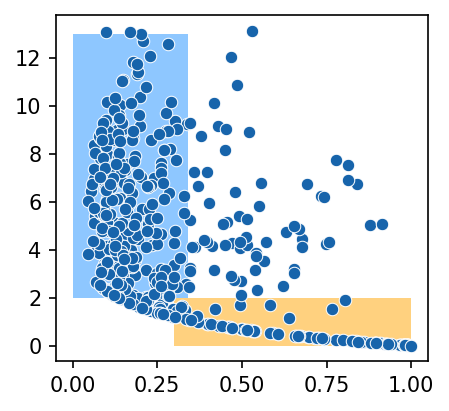

In [1041]:
# label_list = ["Logit", "TSLD_up", "FP"]
palette = sns.color_palette("Blues",24)
label_list = ["FP"]
color_list = [palette[19], "tab:orange", "tab:gray"]
fig, axes = plt.subplots(1, 1, figsize=(3.2, 3), dpi=150)


# axes.axvspan(0, 0.4, facecolor="blue", alpha=0.2)
# axes.axhspan(2, 14, facecolor="blue", alpha=0.2)
# axes.axvspan(0, 0.4, facecolor="blue", alpha=0.2)
from matplotlib.patches import Rectangle
rect = Rectangle((0.001, 2), 0.34, 11, color='dodgerblue', alpha=0.5, edgecolor='none', linewidth=0)
axes.add_patch(rect)
rect = Rectangle((0.3, 0), 0.7, 2, color='orange', alpha=0.5, edgecolor='none', linewidth=0)
axes.add_patch(rect)

for i, name in enumerate(["FP"]):
#     alpha = 0.3 if i == 2 else 1
    alpha=1
    sns.scatterplot(y = ce_conf_dict[f"{name}_ce_loss"], x=ce_conf_dict[f"{name}_conf_list"], alpha=alpha, color=color_list[i])




# axes.axhspan(1/256, y_max, facecolor="orange", alpha=0.2)
# axes.set_ylabel("Per Token CE Loss")
# axes.set_xlabel("Per Token Confidence")
# plt.legend(loc="upper right")

In [1055]:
len(ce_conf_dict[f"{name}_ce_loss"])

255

In [1067]:
idx.sum()

125

In [1339]:
idx = ((ce_conf_dict[f"logit_ce_loss"] > ce_conf_dict[f"FP_ce_loss"])) & ((ce_conf_dict[f"gt_logit_ce_loss"] > ce_conf_dict[f"tsld_ce_loss"]))

In [1291]:
idx = ((ce_conf_dict[f"logit_ce_loss"] > 0)) & ((ce_conf_dict[f"gt_logit_ce_loss"] > 0))

In [1071]:
len(y_axis)

25

In [1292]:
idx.sum()

511

In [1340]:
idx

array([False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False,

ValueError: All arrays must be of the same length

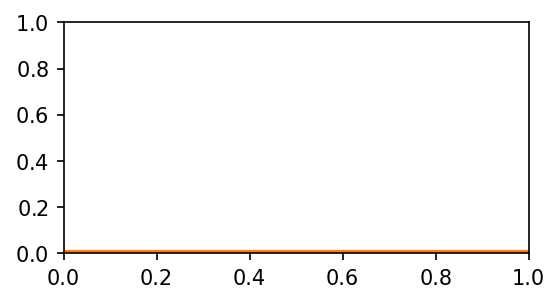

In [1341]:
pred_coeff = torch.nn.functional.softmax(tc_all / 8,dim=0)
under_idx = (pred_coeff < 1/512)
over_idx = (pred_coeff > 1/512)

palette = sns.color_palette("Blues",24)
start = 60
end = 100
length = end - start

under_idx = under_idx[start:end]
over_idx = over_idx[start:end]
palette = sns.color_palette("Blues",24)
color_list = ["tab:gray", palette[20], "tab:green", "tab:blue"]
x_axis = np.arange(length)

y_axis = pred_coeff[idx][start:end].detach().cpu().numpy()

fig, axes = plt.subplots(1, 1, figsize=(4, 2), dpi=150)

from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0,1)) # 이 설정으로 1e-4, 1e-3 등의 범위에서 과학적 표기법을 사용
axes.yaxis.set_major_formatter(formatter)

axes.axhline(y=1/512, label="Logit", color="tab:orange", linewidth=3)
sns.lineplot(x=x_axis, y=y_axis,  ax=axes, color=palette[21],label="TSLD", linewidth=2, linestyle="-", alpha=1, marker="o", markersize=5.5)
y_min = axes.get_ylim()[0]
y_max = axes.get_ylim()[1]
axes.axhspan(y_min, 1/512, facecolor="orange", alpha=0.4)
axes.axhspan(1/512, y_max, facecolor="dodgerblue", alpha=0.4)
# plt.fill_between(x=x_axis, y1=y_axis, y2=1/256, where=under_idx, color='skyblue', alpha=1)  # x < pi 인 영역을 skyblue로 채움
# plt.fill_between(x=x_axis, y1=1/256, y2=y_axis, where=over_idx, color='pink', alpha=1)  # x >= pi 인 영역을 pink로 채움
plt.legend(loc="upper right", ncol=2)



In [1138]:
ce_conf_dict.keys()

dict_keys(['FP_ce_loss', 'FP_conf_list', 'FP_entropy_list', 'l2l_ms_ce_loss', 'l2l_ms_conf_list', 'l2l_ms_entropy_list', 'logit_ce_loss', 'logit_conf_list', 'logit_entropy_list', 'tsld_ce_loss', 'tsld_conf_list', 'tsld_entropy_list'])

In [1240]:
ce_conf_dict["tsld_ce_loss"].sum()

1864.2504

In [1237]:
((ce_conf_dict[f"logit_ce_loss"]  ce_conf_dict[f"tsld_ce_loss"])).sum()

256

(-1.0, 15.0)

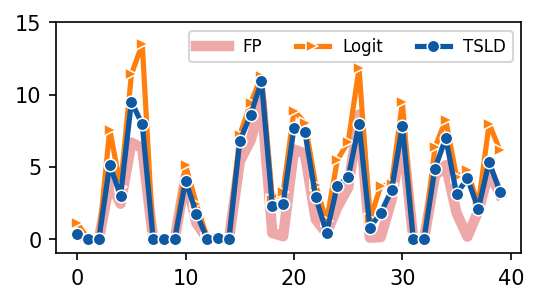

In [1300]:
label_list = ["Logit", "TSLD", "FP"]
start = 60
end = 100
name_list = ["Logit", "TSLD"]
marker_list = [">","o"]

color_list = ["tab:orange", palette[20], "tab:green", "tab:blue"]
palette = sns.color_palette("Blues",24)
fig, axes = plt.subplots(1, 1, figsize=(4, 2), dpi=150)
# axes.axhline(y=0.02, label="Logit", color=color_list[0], linewidth=3)
length = end - start
sns.lineplot(x=np.arange(end-start), y=ce_conf_dict[f"FP_ce_loss"][idx][start:end], color="tab:red", ax=axes, label="FP", alpha=0.4, linewidth=5)
for i, name in enumerate(["gt_logit", "tsld"]):
    # ce_list = ce_conf_dict[f"{model}_{option}_ce_loss"][token_index]
    sns.lineplot(x=np.arange(end-start), y=ce_conf_dict[f"{name}_ce_loss"][idx][start:end], color=color_list[i], ax=axes, label=name_list[i], marker=marker_list[i], alpha=1, markersize=6, linewidth=2.5)
    
# sns.lineplot(x=np.arange(end-start), y=sc_groups[f"{model}_fp_ce_list"][start:end], color="tab:red", ax=axes, label="FP", alpha=0.4, linewidth=5)    
plt.legend(loc="upper right", ncol=3, fontsize=8)
# axes.set_ylabel("Per Token CE Loss")
# axes.set_xlabel("Per Token Index")
plt.ylim(-1, 15)

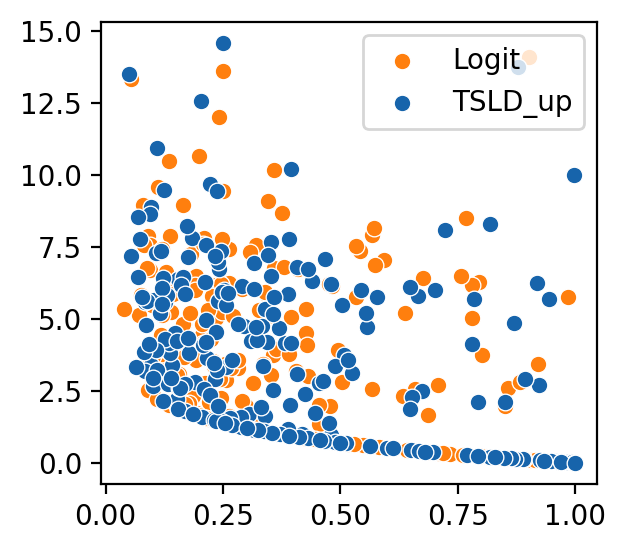

In [1042]:
label_list = ["Logit", "TSLD_up", "FP"]
# label_list = ["Logit", ""]
color_list = ["tab:orange", palette[19], "tab:orange", "tab:gray"]
fig, axes = plt.subplots(1, 1, figsize=(3.2, 3), dpi=200)
for i, name in enumerate(["logit", "tsld"]):
#     alpha = 0.3 if i == 2 else 1
    alpha=1
    sns.scatterplot(y = ce_conf_dict[f"{name}_ce_loss"], x=ce_conf_dict[f"{name}_conf_list"], alpha=alpha, color=color_list[i], label=label_list[i])
# axes.set_ylabel("Per Token CE Loss")
# axes.set_xlabel("Per Token Confidence")
plt.legend(loc="upper right")

## TSLD Scale Plot

In [392]:
tc_all = outputs_fp["loss_all"]
pred_coeff = torch.nn.functional.softmax(tc_all / 10,dim=0)

In [12]:
under_idx = (pred_coeff < 1/256)
over_idx = (pred_coeff > 1/256)

In [329]:
threshold = 1 / seq_len
tsld_up = torch.where(pred_coeff < threshold, torch.ones_like(pred_coeff)*threshold, pred_coeff) 
tsld_down = torch.where(pred_coeff > threshold, torch.ones_like(pred_coeff)*threshold, pred_coeff) 


In [397]:
p_dist = torch.nn.functional.softmax(outputs_fp["logits"][:,], dim=-1)

In [400]:
p_dist[:,21,:].shape

torch.Size([1, 50272])

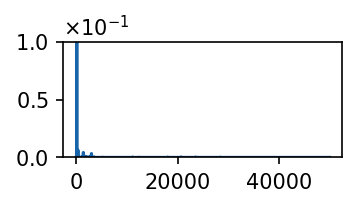

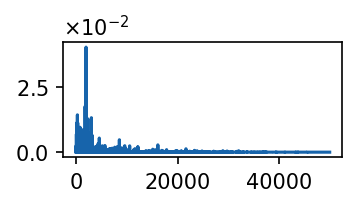

In [882]:
palette = sns.color_palette("Blues",24)
start=0
end = 50000

fig, axes = plt.subplots(1, 1, figsize=(2.4, 1.0), dpi=150)
sns.lineplot(x=np.arange(end-start), y=p_dist[0,47,:][start:end].cpu().detach() ,alpha=1, ax=axes, color=palette[19], linewidth=1.5)
axes.set_ylim(0,0.1)
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0,1)) # 이 설정으로 1e-4, 1e-3 등의 범위에서 과학적 표기법을 사용
axes.yaxis.set_major_formatter(formatter)
start=0
end = 50000
fig, axes = plt.subplots(1, 1, figsize=(2.4, 1.0), dpi=150)
sns.lineplot(x=np.arange(end-start), y=p_dist[0,79,:][start:end].cpu().detach() ,alpha=1, ax=axes, color=palette[19], linewidth=1.5)
# axes.set_ylim(0,0.01)
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0,1)) # 이 설정으로 1e-4, 1e-3 등의 범위에서 과학적 표기법을 사용
axes.yaxis.set_major_formatter(formatter)

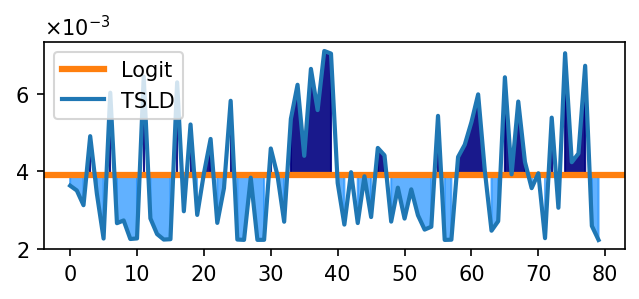

In [576]:
under_idx = (pred_coeff < 1/seq_len)
over_idx = (pred_coeff > 1/seq_len)

palette = sns.color_palette("Set2",24)
start = 100
end = 180
length = end - start

under_idx = under_idx[start:end]
over_idx = over_idx[start:end]

color_list = ["tab:gray", palette[20], "tab:green", "tab:blue"]
x_axis = np.arange(length)

y_axis = pred_coeff[start:end].detach().cpu().numpy()

fig, axes = plt.subplots(1, 1, figsize=(5, 1.8), dpi=150)

axes.axhline(y=1/seq_len, label="Logit", color="tab:orange", linewidth=3, linestyle="-")
sns.lineplot(x=x_axis, y=y_axis,  ax=axes, color="tab:blue",label="TSLD", linewidth=2, linestyle="-", alpha=1)

plt.fill_between(x=x_axis, y1=y_axis, y2=1/seq_len, where=under_idx, color='dodgerblue', alpha=0.7)  # x < pi 인 영역을 skyblue로 채움
plt.fill_between(x=x_axis, y1=1/seq_len, y2=y_axis, where=over_idx, color='navy', alpha=0.9)  # x >= pi 인 영역을 pink로 채움
plt.legend(loc="upper left")
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0,1)) # 이 설정으로 1e-4, 1e-3 등의 범위에서 과학적 표기법을 사용
axes.yaxis.set_major_formatter(formatter)
ylim = axes.get_ylim()
# plt.ylim((0.002570461423601955, 0.006082258012611419))


(0.002470787800848484, 0.007100674137473106)

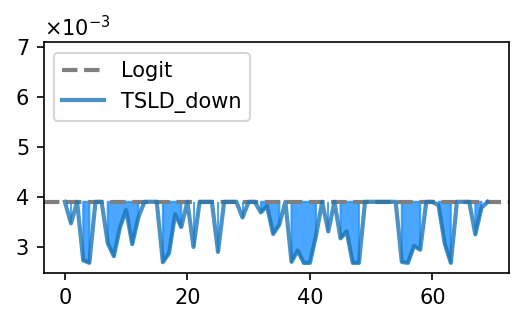

In [380]:
under_idx = (pred_coeff < 1/256)
over_idx = (pred_coeff > 1/256)

palette = sns.color_palette("Blues",24)
length = end - start

under_idx = under_idx[start:end]
over_idx = over_idx[start:end]

color_list = ["tab:gray", palette[20], "tab:green", "tab:blue"]
x_axis = np.arange(length)

y_axis = tsld_down[start:end].detach().cpu().numpy()

fig, axes = plt.subplots(1, 1, figsize=(4, 2), dpi=150)

axes.axhline(y=1/256, label="Logit", color="tab:gray", linewidth=2, linestyle="--")
sns.lineplot(x=x_axis, y=y_axis,  ax=axes, color="tab:blue",label="TSLD_down", linewidth=2, linestyle="-", alpha=0.8)

plt.fill_between(x=x_axis, y1=y_axis, y2=1/256, where=under_idx, color='dodgerblue', alpha=0.8)  # x < pi 인 영역을 skyblue로 채움
plt.fill_between(x=x_axis, y1=1/256, y2=y_axis, where=over_idx, color='pink', alpha=1)  # x >= pi 인 영역을 pink로 채움
plt.legend(loc="upper left")
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0,1)) # 이 설정으로 1e-4, 1e-3 등의 범위에서 과학적 표기법을 사용
axes.yaxis.set_major_formatter(formatter)
# ylim = axes.get_ylim()
plt.ylim(ylim)


(0.002470787800848484, 0.007100674137473106)

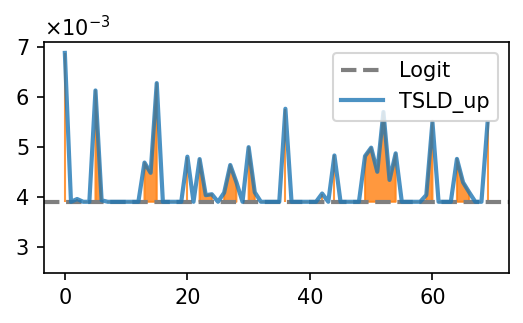

In [383]:
under_idx = (pred_coeff < 1/256)
over_idx = (pred_coeff > 1/256)

palette = sns.color_palette("Blues",24)
length = end - start

under_idx = under_idx[start:end]
over_idx = over_idx[start:end]

color_list = ["tab:gray", palette[20], "tab:green", "tab:blue"]
x_axis = np.arange(length)

y_axis = tsld_up[start:end].detach().cpu().numpy()

fig, axes = plt.subplots(1, 1, figsize=(4, 2), dpi=150)

axes.axhline(y=1/256, label="Logit", color="tab:gray", linewidth=2, linestyle="--", alpha=1)
sns.lineplot(x=x_axis, y=y_axis,  ax=axes, color="tab:blue",label="TSLD_up", linewidth=2, linestyle="-", alpha=0.8)

plt.fill_between(x=x_axis, y1=y_axis, y2=1/256, where=under_idx, color='tab:orange', alpha=0.4)  # x < pi 인 영역을 skyblue로 채움
plt.fill_between(x=x_axis, y1=1/256, y2=y_axis, where=over_idx, color='tab:orange', alpha=0.8)  # x >= pi 인 영역을 pink로 채움
plt.legend(loc="upper right")
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0,1)) # 이 설정으로 1e-4, 1e-3 등의 범위에서 과학적 표기법을 사용
axes.yaxis.set_major_formatter(formatter)
plt.ylim(ylim)


In [21]:
axes.get_ylim()

(0.002570461423601955, 0.006082258012611419)

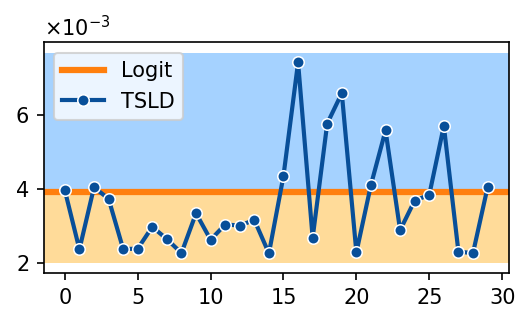

In [1062]:
pred_coeff = torch.nn.functional.softmax(tc_all / 10,dim=0)
under_idx = (pred_coeff < 1/256)
over_idx = (pred_coeff > 1/256)

palette = sns.color_palette("Blues",24)
start = 200
end = 230
length = end - start

under_idx = under_idx[start:end]
over_idx = over_idx[start:end]
palette = sns.color_palette("Blues",24)
color_list = ["tab:gray", palette[20], "tab:green", "tab:blue"]
x_axis = np.arange(length)

y_axis = pred_coeff[start:end].detach().cpu().numpy()

fig, axes = plt.subplots(1, 1, figsize=(4, 2), dpi=150)

from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0,1)) # 이 설정으로 1e-4, 1e-3 등의 범위에서 과학적 표기법을 사용
axes.yaxis.set_major_formatter(formatter)

axes.axhline(y=1/256, label="Logit", color="tab:orange", linewidth=3)
sns.lineplot(x=x_axis, y=y_axis,  ax=axes, color=palette[21],label="TSLD", linewidth=2, linestyle="-", alpha=1, marker="o", markersize=5.5)
y_min = axes.get_ylim()[0]
y_max = axes.get_ylim()[1]
axes.axhspan(y_min, 1/256, facecolor="orange", alpha=0.4)
axes.axhspan(1/256, y_max, facecolor="dodgerblue", alpha=0.4)
# plt.fill_between(x=x_axis, y1=y_axis, y2=1/256, where=under_idx, color='skyblue', alpha=1)  # x < pi 인 영역을 skyblue로 채움
# plt.fill_between(x=x_axis, y1=1/256, y2=y_axis, where=over_idx, color='pink', alpha=1)  # x >= pi 인 영역을 pink로 채움
plt.legend(loc="upper left")



In [80]:
output_flag=True
input_ids = opt_wiki_input_ids
kwargs = {"input_ids" : opt_wiki_input_ids, "labels" : opt_wiki_input_ids, "output_hidden_states" : output_flag, "use_cache" : output_flag, "output_attentions" : output_flag}

outputs_fp = model_opt(**kwargs)
outputs_q = quant_opt(**kwargs)

fp_attn_score = outputs_fp["attention_scores"]
q_attn_score = outputs_q["attention_scores"]


NameError: name 'fp_attn_score' is not defined

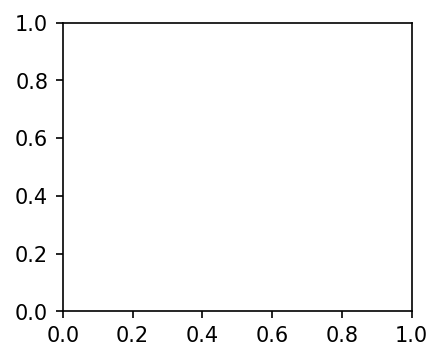

In [155]:
mse_none = MSELoss(reduction="none")

palette_1 = sns.color_palette("flare", 5)
fig, axes = plt.subplots(1, 1, figsize=(3, 2.5), dpi=150)
for i, l in enumerate([2,4,6,8,10]):
#     fig, axes = plt.subplots(1, 1, figsize=(3, 2.5), dpi=150)
    fp_attn_layer = fp_attn_score[l]
    q_attn_layer = q_attn_score[l]
    
    tc_score = fp_attn_layer.squeeze(0).detach().cpu()
    st_score = q_attn_layer.squeeze(0).detach().cpu()
    mse_all = mse_none(tc_score, st_score)
    per_token_mse = mse_all.mean(dim=2).mean(dim=0)
    sns.lineplot(x=np.arange(128), y=per_token_mse, color=palette_1[i], ax=axes, label=f"Layer{l}")

In [778]:
per_

torch.Size([1, 12, 256, 256])

ValueError: Data must be 1-dimensional

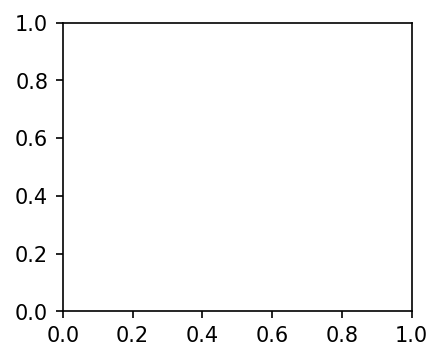

In [777]:
# Attention Output

from matplotlib import ticker
# tick_locator = ticker.MaxNLocator(10)
# fp_attn_output = outputs_fp["attention_outputs"]
# q_attn_output = outputs_q["attention_outputs"]
fp_attn_output = attn_dict["FP"]
q_attn_output = attn_dict["l2l_ms_2"]
fig, axes = plt.subplots(1, 1, figsize=(3, 2.5), dpi=150)
for i, l in enumerate([2,4,6,8,10]):
    fp_attn_layer = fp_attn_output[l]
    q_attn_layer = q_attn_output[l]

    tc_output = fp_attn_layer.squeeze(0).detach().cpu()
    st_output = q_attn_layer.squeeze(0).detach().cpu()
    mse_all = mse_none(tc_output, st_output)
    per_token_mse = mse_all.mean(dim=1)
    sns.lineplot(x=np.arange(128), y=per_token_mse, color=palette_1[i], ax=axes, label=f"Layer{l}")
#     plt.show()




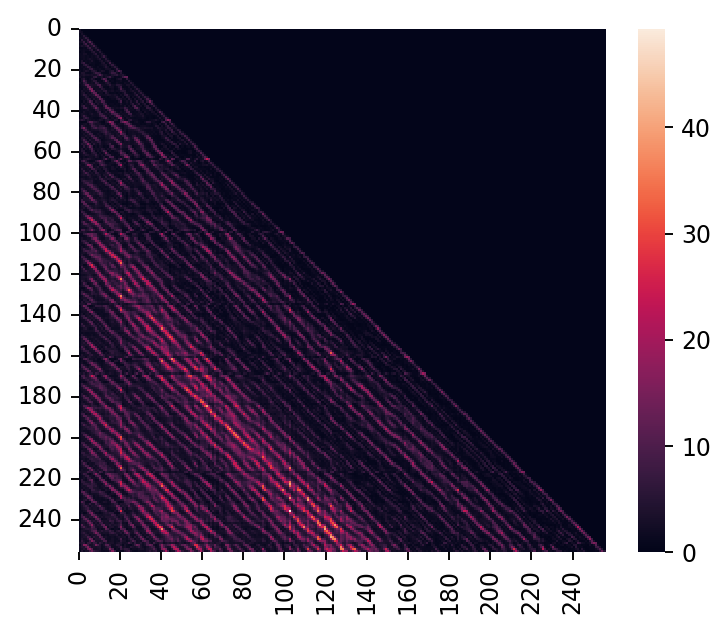

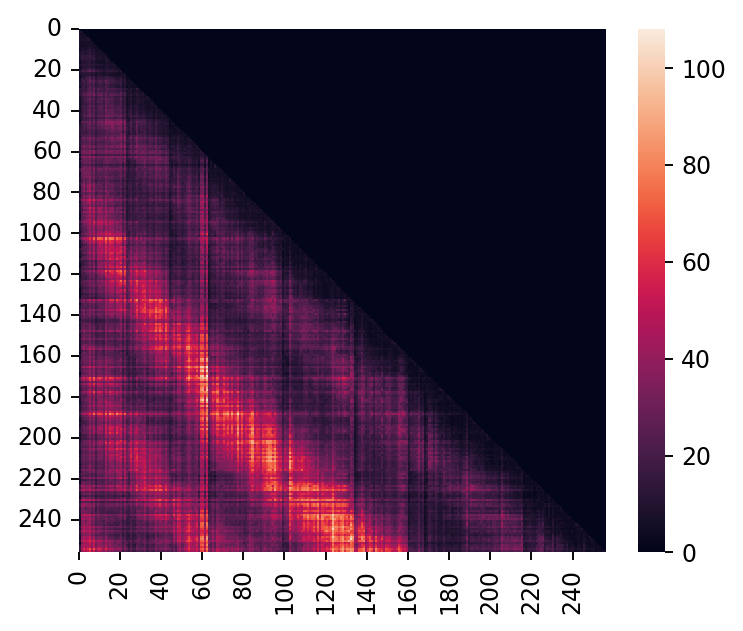

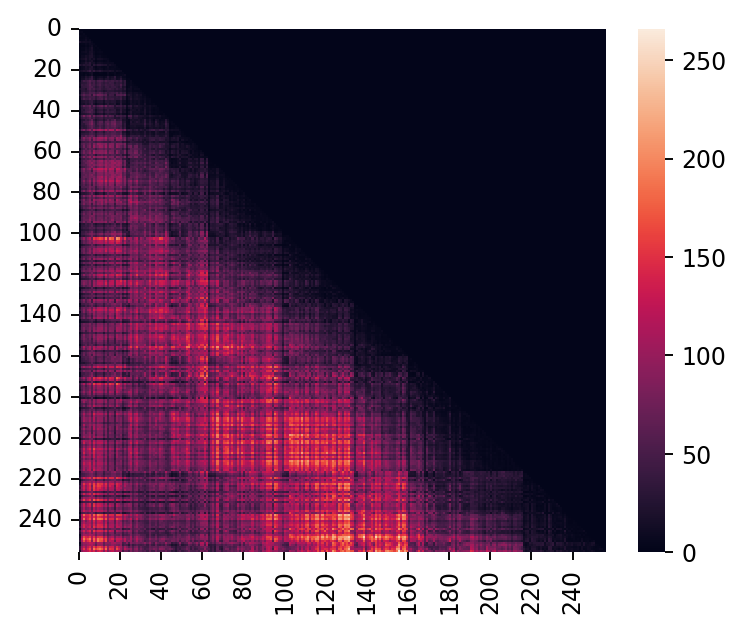

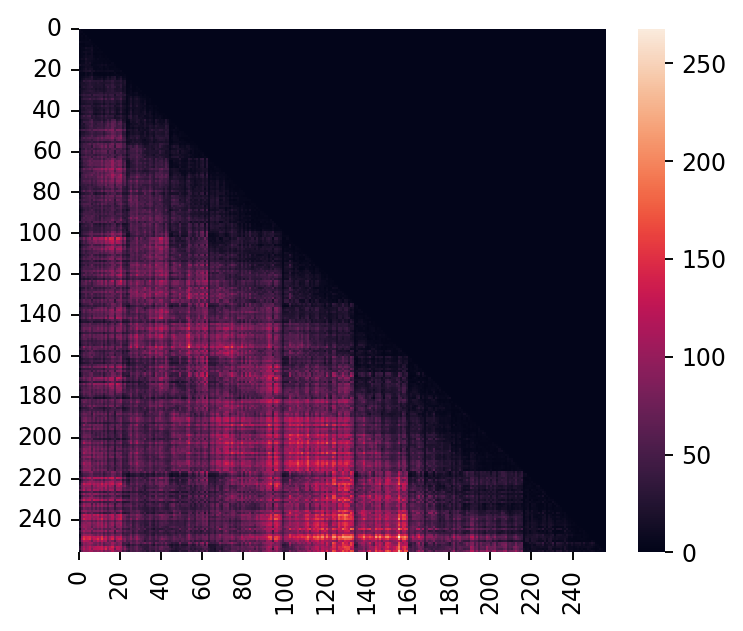

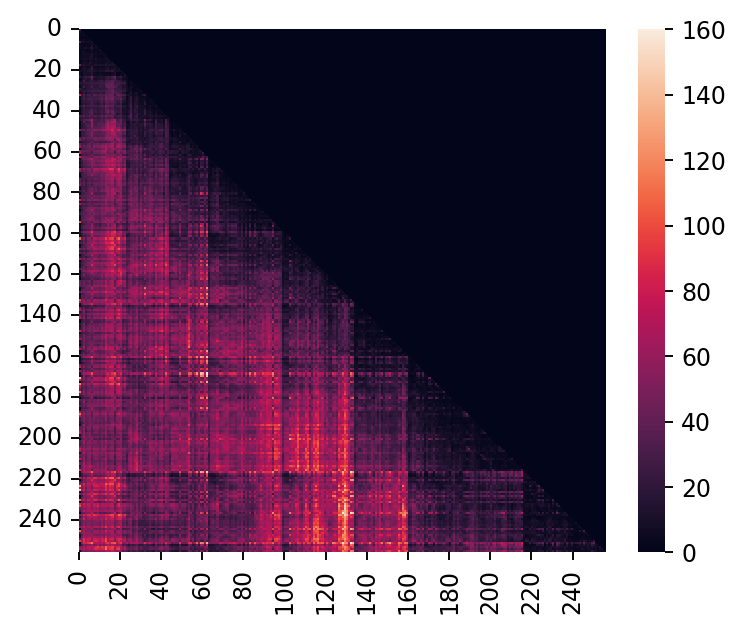

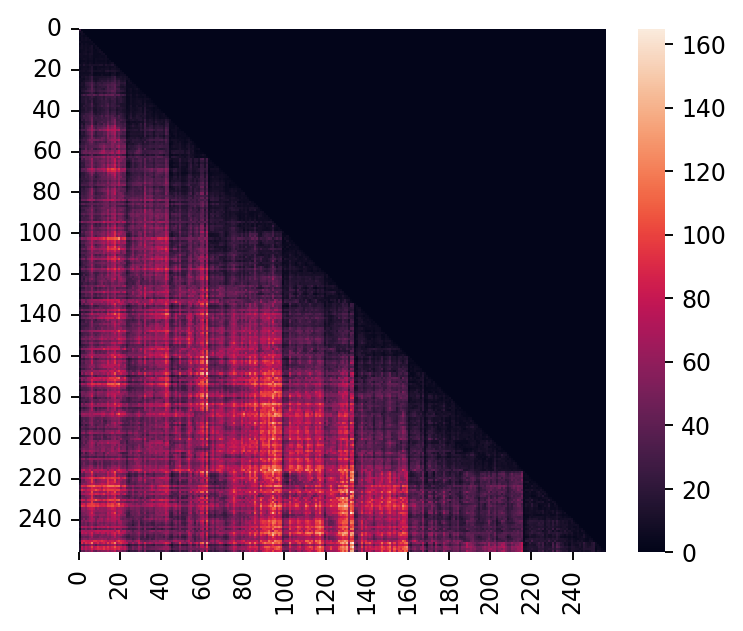

In [786]:

from matplotlib import ticker
# tick_locator = ticker.MaxNLocator(10)

fp_attn_score = attn_dict["FP"]
q_attn_score = attn_dict["Q"]

for l in range(0,12,2):
    fig, axes = plt.subplots(1, 1, figsize=(5, 4), dpi=170)
    fp_attn_layer = fp_attn_score[l]
    q_attn_layer = q_attn_score[l]

    map_diff = ((fp_attn_layer - q_attn_layer)**2).mean(dim=1).squeeze(0).cpu().detach().numpy()
    sns.heatmap(map_diff)
    # plt.title(f"{l} layer")
    plt.xticks(ticks=range(0, 256, 20), labels=range(0,256,20))
    plt.yticks(ticks=range(0, 256, 20), labels=range(0,256,20))
    plt.show()




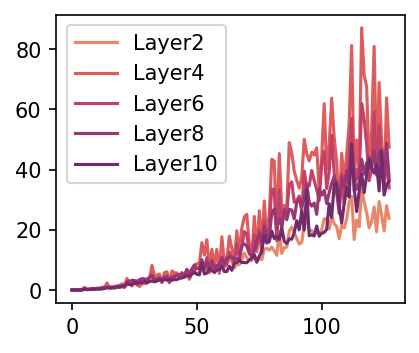

In [86]:
mse_none = MSELoss(reduction="none")

palette_1 = sns.color_palette("flare", 5)
fig, axes = plt.subplots(1, 1, figsize=(3, 2.5), dpi=150)
for i, l in enumerate([2,4,6,8,10]):
#     fig, axes = plt.subplots(1, 1, figsize=(3, 2.5), dpi=150)
    fp_attn_layer = fp_attn_score[l]
    q_attn_layer = q_attn_score[l]
    
    tc_score = fp_attn_layer.squeeze(0).detach().cpu()
    st_score = q_attn_layer.squeeze(0).detach().cpu()
    mse_all = mse_none(tc_score, st_score)
    per_token_mse = mse_all.mean(dim=2).mean(dim=0)
    sns.lineplot(x=np.arange(128), y=per_token_mse, color=palette_1[i], ax=axes, label=f"Layer{l}")
#     axes.set_ylabel("Per-Token Attention MSE")
#     axes.set_xlabel("Token Index") 
#     plt.show()
#     plt.close()
# plt.legend(loc="upper left", fontsize=7)